This is a simple example of Ensemble Kalman Filter (EnKF)

Source library: http://github.com/rlabbe/filterpy

When the filter is initialized a large number of sigma points are drawn from the initial state ($\mathbf{x}$) and covariance ($\mathbf{P}$). During the prediction step the sigma points are passed through the state transition function, and then perturbed by adding a bit of noise to account for the process noise. During the update step the sigma points are translated into measurement space by passing them through the measurement function, they are perturbed by a small amount to account for the measurement noise. 

The steps of EnKF are as follows:

1. Initialisation: This says to select the sigma points from the filter's initial mean and covariance.Here $N$ is the number of sigma points, $\chi$ is the set of sigma points.
$$\boldsymbol\chi \sim \mathcal{N}(\mathbf{x}_0, \mathbf{P}_0)$$
In Python we can write:

```python
N = 1000
sigmas = multivariate_normal(mean=x, cov=P, size=N)
```


2. Prediction
$$
\begin{aligned}
\boldsymbol\chi &= f(\boldsymbol\chi, \mathbf{u}) + v_Q \\
\mathbf{x} &= \frac{1}{N} \sum_1^N \boldsymbol\chi
\end{aligned}
$$

The first line passes all of the sigma points through a use supplied state transition function and then adds some noise distributed according to the $\mathbf{Q}$ matrix. In Python we might write

```python
for i, s in enumerate(sigmas):
    sigmas[i] = fx(x=s, dt=0.1, u=0.)

sigmas += multivariate_normal(x, Q, N)
```

The second line computes the mean from the sigmas. In Python we will take advantage of `numpy.mean` to do this very concisely and quickly.

```python
x = np.mean(sigmas, axis=0)
```
We can now optionally compute the covariance of the mean. The algorithm does not need to compute this value, but it is often useful for analysis. The equation is

$$\mathbf{P} = \frac{1}{N-1}\sum_1^N[\boldsymbol\chi-\mathbf{x}^-][\boldsymbol\chi-\mathbf{x}^-]^\mathsf{T}$$

$\boldsymbol\chi-\mathbf{x}^-$ is a one dimensional vector, so we will use `numpy.outer` to compute the $[\boldsymbol\chi-\mathbf{x}^-][\boldsymbol\chi-\mathbf{x}^-]^\mathsf{T}$ term. In Python we might write

```python
    P = 0
    for s in sigmas:
        P += outer(s-x, s-x)
    P = P / (N-1)
```


3. Update step
In the update step we pass the sigma points through the measurement function, compute the mean and covariance of the sigma points, compute the Kalman gain from the covariance, and then update the Kalman state by scaling the residual by the Kalman gain. The equations are

i) firstly

$$\boldsymbol\chi_h = h(\boldsymbol\chi, u),$$

just passes the sigma points through the measurement function $h$. We name the resulting points $\chi_h$ to distinguish them from the sigma points. In Python we could write this as

```python
sigmas_h = h(sigmas, u)
```
ii) Computes the mean of the measurement sigmas.

$$\mathbf{z}_{mean} = \frac{1}{N}\sum_1^N \boldsymbol\chi_h$$

In Python we write

```python
z_mean = np.mean(sigmas_h, axis=0)
```
    
Now that we have the mean of the measurement sigmas we can compute the covariance for every measurement sigma point, and the *cross variance* for the measurement sigma points vs the sigma points. That is expressed by these two equations

$$
\begin{aligned}
\mathbf{P}_{zz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi_h - \mathbf{z}_{mean}][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T} + \mathbf{R} \\
\mathbf{P}_{xz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi - \mathbf{x}^-][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T}
\end{aligned}$$

We can express this in Python with

```python
P_zz = 0
for sigma in sigmas_h:
    s = sigma - z_mean
    P_zz += outer(s, s)
P_zz = P_zz / (N-1) + R

P_xz = 0
for i in range(N):
    P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
P_xz /= N-1
```
iii) Computation of the Kalman gain is straightforward $\mathbf{K} = \mathbf{P}_{xz} \mathbf{P}_{zz}^{-1}$.

In Python this is

```python
K = np.dot(P_xz, inv(P_zz))```

iv) Next, we update the sigma points with

$$\boldsymbol\chi  = \boldsymbol\chi + \mathbf{K}[\mathbf{z} -\boldsymbol\chi_h + \mathbf{v}_R]$$ 

Here $\mathbf{v}_R$ is the perturbation that we add to the sigmas. In Python we can implement this with

```python
v_r = multivariate_normal([0]*dim_z, R, N)
for i in range(N):
    sigmas[i] += dot(K, z + v_r[i] - sigmas_h[i])
```
v) Our final step is recompute the filter's mean and covariance.

```python
    x = np.mean(sigmas, axis=0)
    P = self.P - dot(K, P_zz).dot(K.T)
```

## Implementation and Example

 This is an example of tracking an object in one dimension. The state vector is

$$\mathbf{x} = \begin{bmatrix}x\\ \dot{x}\end{bmatrix}$$

The state transition function is

$$\mathbf{F} = \begin{bmatrix}1&1\\0&1\end{bmatrix}$$

and the measurement function is

$$\mathbf{H} = \begin{bmatrix}1&0\end{bmatrix}$$

The EnKF is designed for nonlinear problems, so instead of using matrices to implement the state transition and measurement functions you will need to supply Python functions. For this problem they can be written as:

```python
def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return np.dot(F, x)
```

The EnKF code, like the UKF code, uses a single dimension for $\mathbf{x}$, not a two dimensional column matrix as used by the linear kalman filter code.

In [1]:
from numpy.random import randn, multivariate_normal
import numpy as np
from numpy import dot, zeros, eye, outer
import matplotlib.pyplot as plt
from math import cos, sin
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from copy import deepcopy
import copy
import inspect
from collections import defaultdict
from scipy.linalg import expm, block_diag

In [2]:
def Q_discrete_white_noise(dim, dt=1., var=1., block_size=1, order_by_dim=True):
    """
    Returns the Q matrix for the Discrete Constant White Noise
    Model. dim may be either 2, 3, or 4 dt is the time step, and sigma
    is the variance in the noise.
    Q is computed as the G * G^T * variance, where G is the process noise per
    time step. In other words, G = [[.5dt^2][dt]]^T for the constant velocity
    model.
    Parameters
    -----------
    dim : int (2, 3, or 4)
        dimension for Q, where the final dimension is (dim x dim)
    dt : float, default=1.0
        time step in whatever units your filter is using for time. i.e. the
        amount of time between innovations
    var : float, default=1.0
        variance in the noise
    block_size : int >= 1
        If your state variable contains more than one dimension, such as
        a 3d constant velocity model [x x' y y' z z']^T, then Q must be
        a block diagonal matrix.
    order_by_dim : bool, default=True
        Defines ordering of variables in the state vector. `True` orders
        by keeping all derivatives of each dimensions)
        [x x' x'' y y' y'']
        whereas `False` interleaves the dimensions
        [x y z x' y' z' x'' y'' z'']
    Examples
    --------
    >>> # constant velocity model in a 3D world with a 10 Hz update rate
    >>> Q_discrete_white_noise(2, dt=0.1, var=1., block_size=3)
    array([[0.000025, 0.0005  , 0.      , 0.      , 0.      , 0.      ],
           [0.0005  , 0.01    , 0.      , 0.      , 0.      , 0.      ],
           [0.      , 0.      , 0.000025, 0.0005  , 0.      , 0.      ],
           [0.      , 0.      , 0.0005  , 0.01    , 0.      , 0.      ],
           [0.      , 0.      , 0.      , 0.      , 0.000025, 0.0005  ],
           [0.      , 0.      , 0.      , 0.      , 0.0005  , 0.01    ]])
    References
    ----------
    Bar-Shalom. "Estimation with Applications To Tracking and Navigation".
    John Wiley & Sons, 2001. Page 274.
    """

    if not (dim == 2 or dim == 3 or dim == 4):
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]

    if order_by_dim:
        return block_diag(*[Q]*block_size) * var
    return order_by_derivative(array(Q), dim, block_size) * var

In [3]:
class EnKF(object):
    """
    This implements the ensemble Kalman filter (EnKF). The EnKF uses
    an ensemble of hundreds to thousands of state vectors that are randomly
    sampled around the estimate, and adds perturbations at each update and
    predict step. It is useful for extremely large systems such as found
    in hydrophysics. As such, this class is admittedly a toy as it is far
    too slow with large N.

    There are many versions of this sort of this filter. This formulation is
    due to Crassidis and Junkins [1]. It works with both linear and nonlinear
    systems.

    Parameters
    ----------

    x : np.array(dim_x)
        state mean

    P : np.array((dim_x, dim_x))
        covariance of the state

    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.

    dt : float
        time step in seconds

    N : int
        number of sigma points (ensembles). Must be greater than 1.

    K : np.array
        Kalman gain

    hx : function hx(x)
        Measurement function. May be linear or nonlinear - converts state
        x into a measurement. Return must be an np.array of the same
        dimensionality as the measurement vector.

    fx : function fx(x, dt)
        State transition function. May be linear or nonlinear. Projects
        state x into the next time period. Returns the projected state x.


    Attributes
    ----------
    x : numpy.array(dim_x, 1)
        State estimate

    P : numpy.array(dim_x, dim_x)
        State covariance matrix

    x_prior : numpy.array(dim_x, 1)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.

    P_prior : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix. Read Only.

    x_post : numpy.array(dim_x, 1)
        Posterior (updated) state estimate. Read Only.

    P_post : numpy.array(dim_x, dim_x)
        Posterior (updated) state covariance matrix. Read Only.

    z : numpy.array
        Last measurement used in update(). Read only.

    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix

    Q : numpy.array(dim_x, dim_x)
        Process noise matrix

    fx : callable (x, dt)
        State transition function

    hx : callable (x)
        Measurement function. Convert state `x` into a measurement

    K : numpy.array(dim_x, dim_z)
        Kalman gain of the update step. Read only.

    inv : function, default numpy.linalg.inv
        If you prefer another inverse function, such as the Moore-Penrose
        pseudo inverse, set it to that instead: kf.inv = np.linalg.pinv

    Examples
    --------

    .. code-block:: Python

        def hx(x):
           return np.array([x[0]])

        F = np.array([[1., 1.],
                      [0., 1.]])
        def fx(x, dt):
            return np.dot(F, x)

        x = np.array([0., 1.])
        P = np.eye(2) * 100.
        dt = 0.1
        f = EnKF(x=x, P=P, dim_z=1, dt=dt, N=8,
                 hx=hx, fx=fx)

        std_noise = 3.
        f.R *= std_noise**2
        f.Q = Q_discrete_white_noise(2, dt, .01)

        while True:
            z = read_sensor()
            f.predict()
            f.update(np.asarray([z]))

    See my book Kalman and Bayesian Filters in Python
    https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

    References
    ----------

    - [1] John L Crassidis and John L. Junkins. "Optimal Estimation of
      Dynamic Systems. CRC Press, second edition. 2012. pp, 257-9.
    """

    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None]*self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        self.initialize(x, P)
        self.Q = eye(dim_x)       # process uncertainty
        self.R = eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)

    def initialize(self, x, P):
        """
        Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__

        Parameters
        ----------

        x : np.array(dim_z)
            state mean

        P : np.array((dim_x, dim_x))
            covariance of the state
        """

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def update(self, z, R=None):
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.

        Parameters
        ----------

        z : np.array
            measurement for this update.

        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise  self.R will be used.
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = 0
        for sigma in sigmas_h:
            s = sigma - z_mean
            P_zz += outer(s, s)
        P_zz = P_zz / (N-1) + R
        self.S = P_zz
        self.SI = self.inv(self.S)


        P_xz = 0
        for i in range(N):
            P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
        P_xz /= N-1

        self.K = dot(P_xz, self.inv(P_zz))

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - dot(dot(self.K, P_zz), self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict(self):
        """ Predict next position. """

        N = self.N
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self._mean, self.Q, N)
        self.sigmas += e

        P = 0
        for s in self.sigmas:
            sx = s - self.x
            P += outer(sx, sx)

        self.P = P / (N-1)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

In [4]:
def test_1d_const_vel():

    def hx(x):
        return np.array([x[0]])

    F = np.array([[1., 1.],[0., 1.]])
    def fx(x, dt):
        return np.dot(F, x)

    x = np.array([0., 1.])
    P = np.eye(2)* 100.
    f = EnKF(x=x, P=P, dim_z=1, dt=1., N=8, hx=hx, fx=fx)

    std_noise = 10.

    f.R *= std_noise**2
    f.Q = Q_discrete_white_noise(2, 1., .001)

    measurements = []
    results = []
    ps = []
    zs = []
    z = x[0] #initial position
    num_steps =100
    for t in range (0,num_steps):
        # create measurement = t plus white noise
        z = z + 1 + randn()*std_noise
        zs.append(z)

        f.predict()
        f.update(np.asarray([z]))

        # save data
        results.append (f.x[0])
        measurements.append(z)
       # ps.append(3*(f.P[0,0]**.5))        

    results = np.asarray(results)
  #  ps = np.asarray(ps)

    if DO_PLOT:
        plt.plot(results, label='EnKF')
        plt.plot(measurements, c='r', label='z')
       # plt.plot (results-ps, c='k',linestyle='--', label='3$\sigma$')
        #plt.plot(results+ps, c='k', linestyle='--')
        plt.legend(loc='best')
        #print(ps)
    return results, measurements


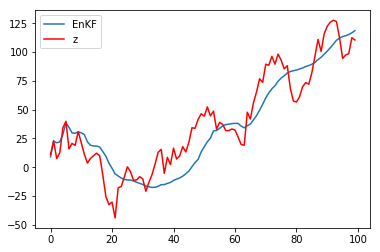

In [5]:
if __name__ == '__main__':
    DO_PLOT = True
    
    test_1d_const_vel()
    #results, measurements=test_1d_const_vel()
    #print(results)
    #print(measurements)    